# Clasificación de CIFAR-100 en Clases y Superclases

## Importación de Librerias

In [43]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Cargar y preparación de datos

In [39]:
(x_train, y_train_fine), (x_test, y_test_fine) = cifar100.load_data(label_mode='fine')
(_, y_train_coarse), (_, y_test_coarse) = cifar100.load_data(label_mode='coarse')

## Trata de Datos

### Normalización de imagenes

In [40]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

### Conversión de etiquetas a codificación one-hot

In [41]:
y_train_fine = to_categorical(y_train_fine, 100)
y_test_fine = to_categorical(y_test_fine, 100)
y_train_coarse = to_categorical(y_train_coarse, 20)
y_test_coarse = to_categorical(y_test_coarse, 20)

### División en entrenamiento y validación

In [42]:
x_train_split, x_val_split, y_train_fine_split, y_val_fine_split, y_train_coarse_split, y_val_coarse_split = train_test_split(
    x_train, y_train_fine, y_train_coarse, test_size=0.2, random_state=42
)

### Generador para manejar ambas etiquetas

In [44]:
class MultiOutputDataGenerator(Sequence):
    def __init__(self, x, y_fine, y_coarse, datagen, batch_size=32, shuffle=True):
        self.x = x
        self.y_fine = y_fine
        self.y_coarse = y_coarse
        self.datagen = datagen
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(x))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_x = self.x[batch_indexes]
        batch_y_fine = self.y_fine[batch_indexes]
        batch_y_coarse = self.y_coarse[batch_indexes]
        
        # Aplicar aumentación de datos
        augmented_x = np.zeros_like(batch_x)
        for i in range(len(batch_x)):
            augmented_x[i] = self.datagen.random_transform(batch_x[i])
        
        return augmented_x, {'fine_output': batch_y_fine, 'coarse_output': batch_y_coarse}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

### Aumentación de datos

In [45]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

### Algo raro

In [47]:
val_datagen = ImageDataGenerator()

batch_size = 64

# Crear generadores
train_generator = MultiOutputDataGenerator(
    x_train_split,
    y_train_fine_split,
    y_train_coarse_split,
    train_datagen,
    batch_size=batch_size
)

val_generator = MultiOutputDataGenerator(
    x_val_split,
    y_val_fine_split,
    y_val_coarse_split,
    val_datagen,
    batch_size=batch_size
)

# Calcular steps
train_steps = len(train_generator)
val_steps = len(val_generator)

## Arquitectura del modelo

### Construcción del modelo CNN con multiples salidas

In [48]:
def build_model():
    input_layer = Input(shape=(32, 32, 3))
    
    # Bloque 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Bloque 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)
    
    # Bloque 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    
    # Capas finales compartidas
    x = GlobalAveragePooling2D()(x)
    
    # Rama para clasificación fina (100 clases)
    fine = Dense(512, activation='relu')(x)
    fine = Dropout(0.5)(fine)
    fine_output = Dense(100, activation='softmax', name='fine_output')(fine)
    
    # Rama para superclases (20 categorías)
    coarse = Dense(256, activation='relu')(x)
    coarse = Dropout(0.4)(coarse)
    coarse_output = Dense(20, activation='softmax', name='coarse_output')(coarse)
    
    model = Model(inputs=input_layer, outputs=[fine_output, coarse_output])
    
    return model

model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 32, 32, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 32, 32, 64)           256       ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 conv2d_7 (Conv2D)           (None, 32, 32, 64)           36928     ['batch_normalization_6[

### Compilación del modelo

In [52]:
optimizer = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
model.compile(
    optimizer=optimizer,
    loss={
        'fine_output': 'categorical_crossentropy',
        'coarse_output': 'categorical_crossentropy'
    },
    metrics={
        'fine_output': 'accuracy',
        'coarse_output': 'accuracy'
    },
    loss_weights={
        'fine_output': 1.0,  # Más peso en la clasificación fina
        'coarse_output': 0.5  # Menos peso en las superclases
    }
)

### Callbacks para entrenamiento

In [53]:
early_stop = EarlyStopping(
    monitor='val_fine_output_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = ModelCheckpoint(
    filepath='checkpoints/cnn_cifar100_multioutput_best.h5',
    monitor='val_fine_output_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_fine_output_accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

## Entrenamiento del Modelo

In [54]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stop, checkpoint_cb, reduce_lr],
    verbose=1
)

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 5.0228 - fine_output_loss: 3.8090 - coarse_output_loss: 2.4276 - fine_output_accuracy: 0.1075 - coarse_output_accuracy: 0.2462
Epoch 1: val_fine_output_accuracy improved from -inf to 0.13920, saving model to checkpoints/cnn_cifar100_multioutput_best.h5


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 201s 319ms/step - loss: 5.0228 - fine_output_loss: 3.8090 - coarse_output_loss: 2.4276 - fine_output_accuracy: 0.1075 - coarse_output_accuracy: 0.2462 - val_loss: 4.7918 - val_fine_output_loss: 3.6283 - val_coarse_output_loss: 2.3269 - val_fine_output_accuracy: 0.1392 - val_coarse_output_accuracy: 0.2720 - lr: 0.0010
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 4.8843 - fine_output_loss: 3.7029 - coarse_output_loss: 2.3629 - fine_output_accuracy: 0.1226 - coarse_output_accuracy: 0.2649
Epoch 2: val_fine_output_accuracy improved from 0.13920 to 0.16340, saving model to checkpoints/cnn_cifar100_multioutput_best.h5
625/625 [==============================] - 224s 358ms/step - loss: 4.8843 - fine_output_loss: 3.7029 - coarse_output_loss: 2.3629 - fine_output_accuracy: 0.1226 - coarse_output_accuracy: 0.2649 - val_loss: 4.6021 - val_fine_output_loss: 3.4885 - val_coarse_output_loss: 2.2271 - val_fine_output_accuracy: 0.1634

### Evaluación y predicción

313/313 [==============================] - 17s 54ms/step - loss: 3.1024 - fine_output_loss: 2.3682 - coarse_output_loss: 1.4684 - fine_output_accuracy: 0.3694 - coarse_output_accuracy: 0.5288

Resultados en el conjunto de prueba:
Pérdida total: 3.102412462234497
Pérdida clases finas: 2.368234872817993
Pérdida superclases: 1.4683549404144287
Precisión clases finas: 0.3693999946117401
Precisión superclases: 0.5288000106811523


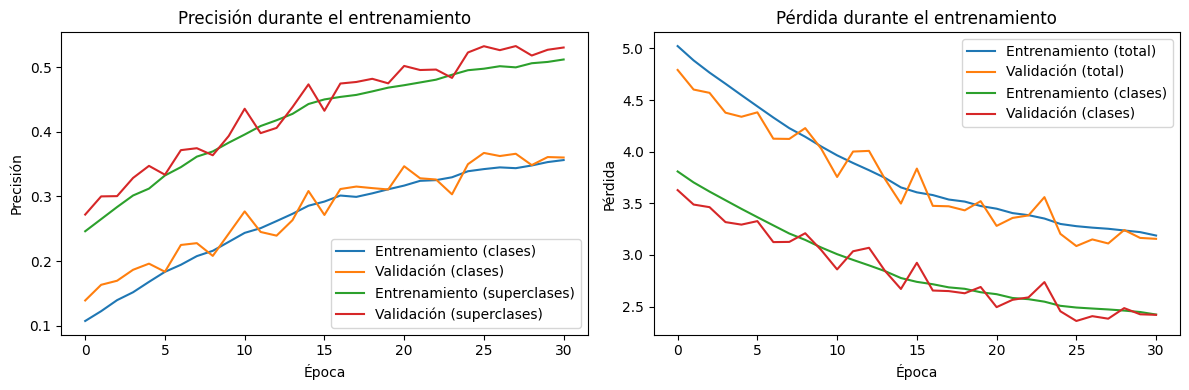

1/1 [==============================] - 0s 192ms/step


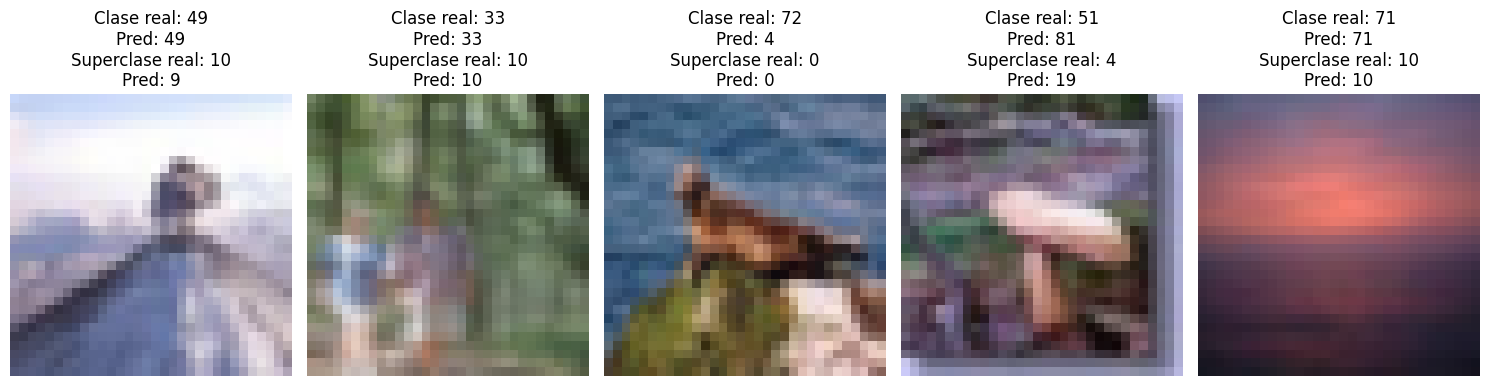

In [55]:
test_results = model.evaluate(
    x_test,
    {'fine_output': y_test_fine, 'coarse_output': y_test_coarse},
    verbose=1
)

print("\nResultados en el conjunto de prueba:")
print(f"Pérdida total: {test_results[0]}")
print(f"Pérdida clases finas: {test_results[1]}")
print(f"Pérdida superclases: {test_results[2]}")
print(f"Precisión clases finas: {test_results[3]}")
print(f"Precisión superclases: {test_results[4]}")

## Visualización de resultados
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['fine_output_accuracy'], label='Entrenamiento (clases)')
    plt.plot(history.history['val_fine_output_accuracy'], label='Validación (clases)')
    plt.plot(history.history['coarse_output_accuracy'], label='Entrenamiento (superclases)')
    plt.plot(history.history['val_coarse_output_accuracy'], label='Validación (superclases)')
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    
    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento (total)')
    plt.plot(history.history['val_loss'], label='Validación (total)')
    plt.plot(history.history['fine_output_loss'], label='Entrenamiento (clases)')
    plt.plot(history.history['val_fine_output_loss'], label='Validación (clases)')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

## Función para mostrar predicciones
def show_predictions(model, x, y_fine, y_coarse, num_samples=5):
    # Obtener predicciones
    fine_pred, coarse_pred = model.predict(x[:num_samples])
    
    # Convertir one-hot a índices
    fine_true = np.argmax(y_fine[:num_samples], axis=1)
    coarse_true = np.argmax(y_coarse[:num_samples], axis=1)
    fine_pred_idx = np.argmax(fine_pred, axis=1)
    coarse_pred_idx = np.argmax(coarse_pred, axis=1)
    
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(x[i])
        plt.title(f"Clase real: {fine_true[i]}\nPred: {fine_pred_idx[i]}\n"
                 f"Superclase real: {coarse_true[i]}\nPred: {coarse_pred_idx[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Mostrar algunas predicciones
show_predictions(model, x_test, y_test_fine, y_test_coarse)